<a href="https://colab.research.google.com/github/marcogemaque/Hell-de-Janeiro/blob/main/Hell_de_Janeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Welcome to Hell-de-Janeiro 0.2.0**

This is a small app built in order to quantify the amount of shootings that happen in the marvelous city. The real focus in here is to "unormalize" the crazy amount of violence we have in Rio, by showing a map of the city and putting into perspective what do we know and also how does the media portray shootings depending on where do they happen.

## **Get Data from API**

In [ ]:
api_key = 'VYxaw4CVKpdtFGXgIzic5GHIl'
api_secret_key = 'Udiqt3beUN6kvKlrMT192Tq8aFNKhztJVOCyPCV5s5rLaEPWKM'
bearer = 'AAAAAAAAAAAAAAAAAAAAAO%2FwLwEAAAAA6YSq3ILZMkqiIYW7yOPrJqWPFys%3Dah7LH54oB6HD1KtAHnuc9YHArxlEGtFih2BrjZq4QMVMWDH2rI'
access_token = '1352216164953452546-HtITyrWZXE7WgibK5VQrAwB0yioCnR'
access_token_secret = 'GBQRAncELZAXxYLjN5AF9usNPGkMhUHKI5ZpeVNetS7Ps'

In [ ]:
!pip install tweepy

In [6]:
import requests
import json
import tweepy
import pandas as pd
import re
import time

In [ ]:
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(api_key, api_secret_key)
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth)
    return api

def transform_tweets(tweet_obj):
    #Transform tweet object texts to lists
    list_tweets = [] #Empty list to store tweets
    for tweet in tweet_obj:
        tweet_date = tweet.created_at
        tweet_text = tweet.text
        tweet_id = tweet.id
        list_tweets.append({'date':tweet_date,
                            'content':tweet_text,
                            'id':tweet_id})
        
    #Create dataframe
    df = pd.DataFrame(list_tweets, columns=['date','content','id'])
    return df

#Create API object
api = connect_to_twitter_OAuth()

#Create function to retrieve more tweets
def twitter_scraper():
    api = connect_to_twitter_OAuth()
    ott = api.user_timeline('RJ_OTT', count=200)
    df_inside = transform_tweets(ott)
    result = df_inside
    for i in range(59):
        try:
            time.sleep(1) #sleep for 1 second
            last_id = result['id'].values[-1]
            ott = api.user_timeline('RJ_OTT', count=200, max_id=str(last_id))
            df_inner = transform_tweets(ott)
            list_dfs = [result, df_inner]
            result = pd.concat(list_dfs)
            result = result.sort_values(by=['id'], ascending=False)
        except:
            pass
    return result

df_tweets = twitter_scraper()
df = df_tweets.copy() #create a copy so we can always change the outlet dataframe

In [ ]:
df.tail()

,date,content,id
0,2019-04-02 09:35:02,OTT-RJ Informa:\n\n02/04 - 06:25h\n\nTiros na ...,1113011950844329985
0,2019-04-02 09:35:02,OTT-RJ Informa:\n\n02/04 - 06:25h\n\nTiros na ...,1113011950844329985
0,2019-04-02 09:35:02,OTT-RJ Informa:\n\n02/04 - 06:25h\n\nTiros na ...,1113011950844329985
0,2019-04-02 09:35:02,OTT-RJ Informa:\n\n02/04 - 06:25h\n\nTiros na ...,1113011950844329985
0,2019-04-02 09:35:02,OTT-RJ Informa:\n\n02/04 - 06:25h\n\nTiros na ...,1113011950844329985


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3262 entries, 0 to 0
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3262 non-null   datetime64[ns]
 1   content  3262 non-null   object        
 2   id       3262 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 101.9+ KB


## **Wrangle the database**

We have some ways in which the tweets were written. The main captured standards were: <br>
1) Local: xxx, Rio de Janeiro <br>
2) Local: xxx <br>
3) Tiros ouvidos na/em xxx <br>
4) Tiros na/em xxx <br>
5) Disparos ouvidos em/no xxx <br>
A major way to split would be to catch the first occurence of a comma (","), since this is a common character splitting. We need regex for all other standards as well. Perhaps a common function would be better to use which comprises of all the possible methods instead of writing multiple lines of regex. But we'll see.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/drive/My Drive/Hell-de-Janeiro App/output.csv')

In [24]:
#Drop columns
df = df.drop(['Unnamed: 0'], axis=1)

In [25]:
df.head()

,date,content,id
0,2021-01-24 13:08:29,Tiroteio - 24/01/2021 às 10:06\nLocal: Pilares...,1353328823266398216
1,2021-01-24 03:27:35,Disparos ouvidos - 24/01/2021 às 00:20h\nLocal...,1353182632897622017
2,2021-01-24 03:22:18,Disparos ouvidos - 24/01/2021 às 00:00h\nLocal...,1353181303441682438
3,2021-01-24 01:13:09,OTT-RJ INFORMA:\n\n23/01 - 21:43h\nTiros emBel...,1353148801989672961
4,2021-01-23 06:51:57,Tiroteio - 23/01/2021 às 03:36h\nLocal: Andara...,1352871674924957696


In [26]:
"""
So this is how things are going to be.
1) Create regex expression to filter dataframe
2) Get indexes of filtered entries by regex
3) On to the next regex expression, remove the indexes from the previous created regex
"""

#Standard Local: xxx, Rio de Janeiro or Local: xxx
df_out = df.copy()
df_out['content'] = df['content'].str.split(r"\s*Local:", expand=True)[1]
df_out['content'] = df_out['content'].str.split(r"\s*Rio de Janeiro|\n", expand=True)[0]
df_out['content'] = df_out['content'].str.replace(r"^\s", "")
df_out = df_out.dropna()

"""
#Deprecated section of code. Update on 2021-02-03
list_index = df_out.index.values.tolist()

#Get the same dataframe, but this time remove the indexes you have retrieved
df_own = df.drop(list_index)

#Get the second regex
df_out2 = df_own['content'].str.split(r"\s*Tiros em|Tiros na", expand=True)[1]
df_out2 = df_out2.str.split(",", expand=True)[0]
df_out2 = df_out2.str.replace(r"^\s", "")
df_out2 = pd.DataFrame(df_out2)
df_out2 = df_out2.dropna()
df_out2.columns = ['Place']

#Get the same dataframe, but this time remove the indexes you have retrieved before
list_index.extend(df_out2.index.values.tolist())
df_own = df.drop(list_index)

#Get the third regex
df_out3 = df_own['content'].str.split(r"\s*no |em |na ", expand=True)[1]
df_out3 = df_out3.str.split(",", expand=True)[0]
df_out3 = df_out3.str.replace(r"^\s", "")
df_out3 = pd.DataFrame(df_out3)
df_out3 = df_out3.dropna()
df_out3.columns = ['Place']
df_out3.head()

#Get the same dataframe, but this time remove the indexes you have retrieved before
list_index.extend(df_out3.index.values.tolist())
df_own = df.drop(list_index)
"""

'\n#Deprecated section of code. Update on 2021-02-03\nlist_index = df_out.index.values.tolist()\n\n#Get the same dataframe, but this time remove the indexes you have retrieved\ndf_own = df.drop(list_index)\n\n#Get the second regex\ndf_out2 = df_own[\'content\'].str.split(r"\\s*Tiros em|Tiros na", expand=True)[1]\ndf_out2 = df_out2.str.split(",", expand=True)[0]\ndf_out2 = df_out2.str.replace(r"^\\s", "")\ndf_out2 = pd.DataFrame(df_out2)\ndf_out2 = df_out2.dropna()\ndf_out2.columns = [\'Place\']\n\n#Get the same dataframe, but this time remove the indexes you have retrieved before\nlist_index.extend(df_out2.index.values.tolist())\ndf_own = df.drop(list_index)\n\n#Get the third regex\ndf_out3 = df_own[\'content\'].str.split(r"\\s*no |em |na ", expand=True)[1]\ndf_out3 = df_out3.str.split(",", expand=True)[0]\ndf_out3 = df_out3.str.replace(r"^\\s", "")\ndf_out3 = pd.DataFrame(df_out3)\ndf_out3 = df_out3.dropna()\ndf_out3.columns = [\'Place\']\ndf_out3.head()\n\n#Get the same dataframe, bu

In [27]:
df_out['content'] = df_out['content'].str.replace(r"^\s", "") #replaces blank space ahead
df_out['content'] = df_out['content'].str.replace(r"\s$", "") #replaces blank space at the end or dot
df_out['content'] = df_out['content'].apply(lambda x: x.split("(")[0] if "(" in x else x) #removes everything after "("
df_out['content'] = df_out['content'].apply(lambda x: x.split("-")[0] if "-" in x else x) #removes everything after "-"
df_out['content'] = df_out['content'].apply(lambda x: x.split("/")[0] if "/" in x else x) #removes everything after "/"
df_out['content'] = df_out['content'].apply(lambda x: x.split(".")[0] if "." in x else x) #removes everything after "."
df_out['content'] = df_out['content'].apply(lambda x: x.split(",")[0] if "," in x else x) #removes everything after ","
df_out['content'] = df_out['content'].apply(lambda x: x.split(r" Rio de J")[0] if " Rio de J" in x else x) #removes everything after " Rio de Jan"
df_out['content'] = df_out['content'].apply(lambda x: x.split(r" e ")[0] if " e " in x else x) #removes everything after " e "
df_out['content'] = df_out['content'].apply(lambda x: x.rstrip()) #removes whitespace at the end of the string

In [31]:
uniques = df_out['content'].unique()
uniques

array(['Pilares', 'Rio Comprido', 'Piedade', 'Andaraí', 'Praça Seca',
       'Cascadura', 'Belford Roxo', 'Brás de Pina', 'Maré',
       'Duque de Caxias', 'Quintino Bocaiuva', 'Senador Camará',
       'Catumbi', 'Complexo do Alemão', 'Madureira', 'Costa Barros',
       'Vila Kennedy', 'Leme', 'Angra dos Reis', 'São Gonçalo', 'Japeri',
       'Cosme Velho', 'Jardim América', 'Caju', 'Mangueira', 'Magé',
       'Centro', 'Glória', 'Cavalcanti', 'Quintino', 'Jacarezinho',
       'Engenho da Rainha', 'Complexo da Maré', 'Penha', 'Mesquita',
       'Morro do Estado', 'Praça da Bandeira', 'Vila Isabel',
       'Complexo da Penha', 'Santa Teresa', 'Cordovil', 'Manguinhos',
       'Anchieta', 'Cidade de Deus', 'Bonsucesso', 'Grajaú',
       'Engenheiro Pedreira', 'Caxias', 'Copacabana', 'Laranjeiras',
       'Tijuca', 'Magalhães Bastos', 'Santo Cristo', 'Irajá', 'Estácio',
       'Benfica', 'Vasco da Gama', 'Cidade Universitária',
       'Penha Circular', 'Niterói', 'Complexo do Lins', 'Macaé

In [52]:
df_out = df_out.drop([530])

In [95]:
locations = {'Pilares':[-22.8814,-43.2835],
             'Rio Comprido':[-22.9252, -43.2053],
             'Piedade':[-22.8963, -43.3127],
             'Andaraí':[-22.9260, -43.2487],
             'Praça Seca':[-22.8969, -43.3517],
             'Cascadura':[-22.8822, -42.3246],
             'Belford Roxo':[-22.7645, -43.39960],
             'Brás de Pina':[-22.7645, -43.39960],
             'Maré':[-22.8554,-43.2422],
             'Duque de Caxias':[-22.7863, -43.3053],
             'Quintino Bocaiuva':[-22.8876, -43.3192],
             'Senador Camará':[-22.8795,-43.4893],
             'Catumbi':[-22.9167, -43.1962],
             'Complexo do Alemão':[-22.8594,-43.2754],
             'Madureira':[-22.8725, -43.3364],
             'Costa Barros':[-22.8243,-43.3727],
             'Vila Kennedy':[-22.8604,-43.4884],
             'Leme':[-22.9615,-43,1662],
             'Angra dos Reis':[-23.0057,-44.3158],
             'São Gonçalo':[-22.8273,-43.0638],
             'Japeri':[-22.6438,-43.6601],
             'Cosme Velho':[-22.5634, -43.1200],
             'Jardim América':[-22.8115, -43.3207],
             'Caju':[-22.8799,-43.2264],
             'Mangueira':[-22.9053,-43.5340],
             'Magé':[-22.6566,-43.0398],
             'Centro':[-22.9071,-43.1819],
             'Glória':[-22.9204,-43.1745],
             'Cavalcanti':[-22.8699,-43.3161],
             'Quintino':[-22.8876,-43.3192],
             'Jacarezinho':[-22.8876,-43.2582],
             'Engenho da Rainha':[-22.5147,-43.1744],
             'Complexo da Maré':[-22.8554,-43.2422],
             'Penha':[-22.8372,-43.2774],
             'Mesquita':[-22.7819,-43.4293],
             'Morro do Estado':[-22.8990,-43.1193],
             'Praça da Bandeira':[-22.9102,-43.2122],
             'Vila Isabel':[-22.9166,-43.2502],
             'Complexo da Penha':[-22.5100, -43.1900],
             'Santa Teresa':[-22.9163,-43.1916],
             'Cordovil':[-22.8234,-43.2959],
             'Manguinhos':[-22.8830,-43.2458],
             'Anchieta':[-22.8208,-43.3969],
             'Cidade de Deus':[-22.9465,-43.3697],
             'Bonsucesso':[-22.8627,-43.2540],
             'Grajaú':[-22.9237,-43.2585],
             'Engenheiro Pedreira':[-22.6783,-43.6063],
             'Caxias':[-22.7863,-43.6053],
             'Copacabana':[-22.9694,-43.1868],
             'Laranjeiras':[-22.9332,-43.1847],
             'Tijuca':[-22.9326,-43.2410],
             'Magalhães Bastos':[-22.8718,-43.4139],
             'Santo Cristo':[-22.8996,-43.2014],
             'Irajá':[-22.8443,-43.3232],
             'Estácio':[-22.9174,-43.2050],
             'Benfica':[-22.8942,-43.2391],
             'Vasco da Gama':[-22.8910,-43.2268],
             'Cidade Universitária':[-22.8627,-43.2259],
             'Penha Circular':[-22.8393,-43.2914],
             'Niterói':[-22.8859,-43.1153],
             'Complexo do Lins':[-22.5452,-43.1658],
             'Macaé':[-22.3234,-41.9593],
             'Ilha do Governador':[-22.8052,-43.2086],
             'Catete':[-22.9280,-43.1808],
             'Pavuna':[-22.8122,-43.3620],
             'Engenho Novo':[-22.9081,-43.2678],
             'Campinho':[-22.8856,-43.3481],
             'São Francisco Xavier':[-22.5412,-43.1436],
             'Jacaré':[-22.8923,-43.2582],
             'Vaz Lobo':[-22.5133,-43.1944],
             'Realengo':[-22.8787,-43.4285],
             'Itaguaí':[-22.8632,-43.7779],
             'Nova Iguaçu':[-22.7561,-43.4607],
             'Providência':[-22.5403,-41.1147],
             'São João de Meriti':[-22.7908,-43.3699],
             'Vila Cruzeiro':[-22.8502,-43.2812],
             'Taquara':[-22.9230,-43.3740],
             'Encantado':[-22.8960,-43.3022],
             'Nilópolis':[-22.8098,-43.4194],
             'Maricá':[-22.9161,-42.8192],
             'Recreio':[-23.0175,-43.4626],
             'Botafogo':[-22.9512,-43.1808],
             'Bancários':[-22.7910,-43.1809],
             'Cachambi':[-22.8900,-43.2736],
             'Lins de Vasconcelos':[-22.5448,-43.1705],
             'Arraial do Cabo':[-22.9673,-42.0268],
             'Tanguá':[-22.7428,-42.7206],
             'Rocha Miranda':[-22.8521,-43.3468],
             'Santa Marta':[-22.5661,-43.1138],
             'Del Castilho':[-22.8804,-43.2690],
             'Guadalupe':[-22.8401,-43.3781],
             'Ingá':[-22.9038,-43.1222],
             'Lins':[-22.5452,-43.1658],
             'Rio das Ostras':[-22.5273,-41.9464],
             'Freguesia':[-22.9383,-43.3408],
             'Conceição de Macabu':[-22.0839,-41.8723],
             'Pechincha':[-22.9289,-43.3542],
             'Barra Mansa':[-22.5409,-44.1773],
             'Itatiaia':[-22.4913,-44.5721],
             'Ilha Grande':[-23.1521,-44.2289],
             'São Cristóvão':[-22.8996,-43.2227],
             'Tomás Coelho':[-22.8682,-43.3044],
             'Ramos':[-22.8503,-43.2566],
             'Honório Gurgel':[-22.8454,-43.3547],
             'Lagoa':[-22.9621,-43.2077],
             'Campo Grande':[-22.9077,-43.5659],
             'Galeão':[-22.8171,-43.2278],
             'Tanque':[-22.9183,-43.3609],
             'Méier':[-22.9022,-43.2803],
             'Bangu':[-22.8742,-43.4685],
             'Água Santa':[-22.9056,-43.3082],
             'Vicente de Carvalho':[-22.8558,-43.3158]}

In [96]:
df_final = df_out.copy()

In [122]:
df_final['lat'] = df_final['content'].apply(lambda x: locations[x][0])
df_final['lon'] = df_final['content'].apply(lambda x: locations[x][1])
counts = df_final['content'].value_counts()
df_final['size'] = df_final['content'].apply(lambda x: counts[x])

In [123]:
counts = df_final['content'].value_counts()

In [124]:
df_final.head()

,date,content,id,lat,lon,size
0,2021-01-24 13:08:29,Pilares,1353328823266398216,-22.8814,-43.2835,3
1,2021-01-24 03:27:35,Rio Comprido,1353182632897622017,-22.9252,-43.2053,14
2,2021-01-24 03:22:18,Piedade,1353181303441682438,-22.8963,-43.3127,4
4,2021-01-23 06:51:57,Andaraí,1352871674924957696,-22.9260,-43.2487,31
5,2021-01-23 06:29:29,Andaraí,1352866024119529472,-22.9260,-43.2487,31


### **EDA**
Simple EDA to try and understand our data a little bit better.

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

In [112]:
value_counts = df_final['content'].value_counts()
value_counts = value_counts[:10]

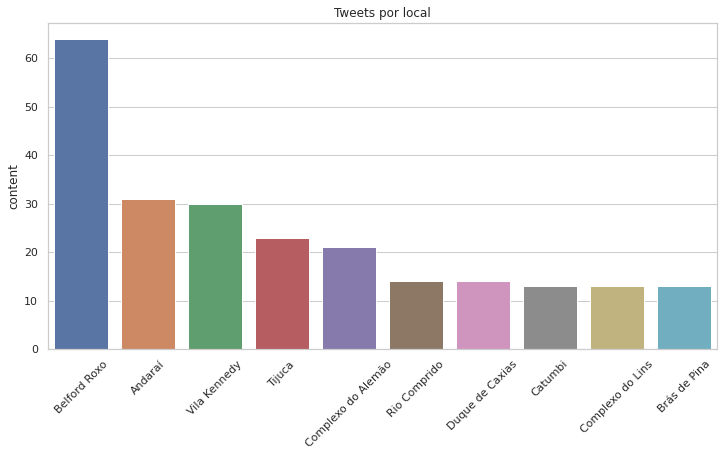

In [113]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.set(style="whitegrid")
ax = sns.barplot(x=value_counts.index, y=value_counts).set_title('Tweets por local')

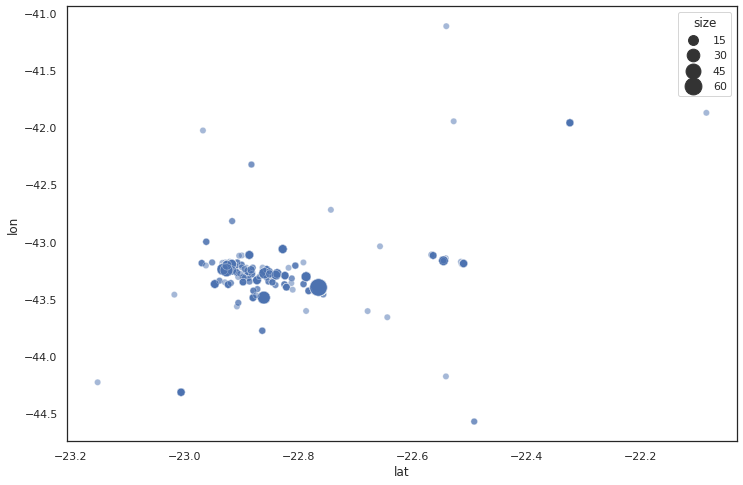

In [127]:
sns.set(style="white")
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='lat', y='lon', data=df_final, alpha=0.5, palette='muted', size='size',
                     sizes=(40,300))

### **Deprecated code**

In [ ]:
df_work = pd.DataFrame()
df_work['Place'] = df_out['Place']
df_work = pd.concat([df_work, df_out2, df_out3])
df_work['date'] = df['date'].iloc[df_work.index.values.tolist()]
df_work = df_work.reset_index(drop=True)

KeyError: ignored

In [ ]:
df_work['Place'] = df_work['Place'].str.replace(r"^\s", "") #replaces blank space ahead
df_work['Place'] = df_work['Place'].str.replace(r"\s$", "") #replaces blank space at the end or dot
df_work['Place'] = df_work['Place'].apply(lambda x: x.split("(")[0] if "(" in x else x) #removes everything after "("
df_work['Place'] = df_work['Place'].apply(lambda x: x.split("-")[0] if "-" in x else x) #removes everything after "-"
df_work['Place'] = df_work['Place'].apply(lambda x: x.split("/")[0] if "/" in x else x) #removes everything after "/"
df_work['Place'] = df_work['Place'].apply(lambda x: x.split(".")[0] if "." in x else x) #removes everything after "."

In [ ]:
df_work['Place'].unique()

array(['Pilares', 'Rio Comprido', 'Piedade', 'Andaraí', 'Praça Seca',
       'Cascadura', 'Belford Roxo', 'Brás de Pina', 'Maré',
       'Duque de Caxias', 'Quintino Bocaiuva', 'Senador Camará',
       'Catumbi', 'Complexo do Alemão', 'Madureira', 'Costa Barros',
       'Vila Kennedy', 'Leme', 'Angra dos Reis', 'São Gonçalo', 'Japeri',
       'Cosme Velho', 'Jardim América', 'Caju', 'Mangueira', 'Magé',
       'Centro', 'Cosme Velho ', 'Glória', 'Piedade ', 'Belford Roxo ',
       'Costa Barros ', 'Madureira ', 'Complexo do Alemão ', 'Cavalcanti',
       'Quintino', 'Jacarezinho', 'São Gonçalo ', 'Engenho da Rainha',
       'Complexo da Maré', 'Penha ', 'Mesquita ', 'Morro do Estado',
       'Praça da Bandeira', 'Vila Isabel', 'Complexo da Penha',
       'Santa Teresa ', 'Cordovil', 'Manguinhos', 'Anchieta',
       'Cidade de Deus', 'Penha', 'Bonsucesso', 'Grajaú',
       'Belford Roxo  ', 'Engenheiro Pedreira ', 'Senador Camará  ',
       'Vila Kennedy ', 'Caxias', 'Copacabana', 'Mesq

We have filtered the dataframe as best as we can, now we need to clean out the wrong values.

## **Frustrated Dev Diary**

**Entry 21-01-2021** <br>
Another day, another project. Created Twitter's development account and officially began the project. Shoutout to @saramalvar for supporting it and helping on it. <br>

**Entry 22-01-2021:** <br>
Tweets have been posted on a dataframe. Df's limit is of 20 tweets by the method
we imported, so we'll have to think a way of expanding it, but we'll create the
regex for the 20 just as a start. We have tweet date (to take the year and month) and text so we can create the real dataframe with divisions by columns. <br>
The idea is: if the dataframe doesn't have place description then we disregard the input. <br>

**Entry 25-01-2021:** <br>
I believe we collected almost all useful tweets. We used 3 sets of regex and ran on our database of tweets collected from the API. Out of the 3200 tweets we used 3000. The remanining ones (tails and heads of df checked for this) seemed to be mentions asking where did the shootings happened and other similar. Branding as well. <br>

**Entry 03-02-2021:** <br>
We gave up on regexing everything. Finally we have found a way to have 500 tweets, which is a fair amount of tweets, so now we're on to finding an API which allows us to actually get the coordinates and then plot our map.

## **Change Log**
**Version 0.2.0:** Reduced the amount of regex calculated. Now we use only the standard tweet with shot and place instead of trying to fetch all.